### Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import pickle as pkl
import mlflow

### Lectura de datos

In [2]:
def load_data():
    """
    Función para cargar los datos
    """
    data = pd.read_csv('clean_data.csv')
    data['examen_periodo'] = data['periodo'].astype(str).str.slice(-1).astype(int).clip(upper=2, lower=1)
    data = data.drop(columns=['estudiante_fechanacimiento', 'colegio_nombre', 'estudiante_municipio', 'puntaje_global', 'colegio_municipio', 'estudiante_departamento', 'periodo'])
    categorical_columns = data.select_dtypes(include=['object']).columns
    for column in categorical_columns:
        data[column] = data[column].fillna('DESCONOCIDO')
    data = pd.get_dummies(data, sparse=True)
    targets = ['puntaje_ingles', 'puntaje_matematicas', 'puntaje_sociales_ciudadanas', 'puntaje_ciencias_naturales', 'puntaje_lectura_critica']
    X = data.drop(columns=targets).to_numpy().astype(np.float32)
    Y= data[targets].to_numpy().astype(np.float32)
    Y = Y / 100
    return X, Y, data

### Arquitectura

In [9]:
def get_model(num_hidden_layers, num_hidden_units, activation_func):
    """
    Arquitectura de la red
    """
    # Definir el modelo
    model = Sequential()
    model.add(Dense(512, activation=activation_func, kernel_regularizer=l2(0.01), input_dim=68))

    # Capas ocultas
    for n in range(num_hidden_layers):
        model.add(Dense(num_hidden_units, activation=activation_func, kernel_regularizer=l2(0.01)))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(5, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Resumen del modelo
    print(model.summary())

    return model

### Entrenamiento

In [4]:
def train_neural_network(model, X_train, y_train, epochs):
    """
    Entrenamiento del clasificador
    """

    checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)    

    # Entrenar el modelo
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=300000,
        validation_split=0.3,
        validation_batch_size=300000,
        callbacks=[early_stopping, checkpoint]
    )

    return history

### Métricas

In [5]:
def calculate_metrics(y_real, y_pred):
    """
    Cálculo de métricas (regresión) de evaluación del modelo
    """
    # Calcular el error cuadrático medio
    mse = np.mean((y_real - y_pred)**2)

    # Calcular el error absoluto medio
    mae = np.mean(np.abs(y_real - y_pred))

    # Calcular el coeficiente de determinación
    r2 = 1 - np.sum((y_real - y_pred)**2) / np.sum((y_real - np.mean(y_real))**2)

    print(f"Error cuadrático medio: {mse}")
    print(f"Error absoluto medio: {mae}")
    print(f"Coeficiente de determinación: {r2}")

### Visualización de resultados

In [6]:
def visualize_training(history):
    """
    Visualización del entrenamiento
    """
    # Generar y mostrar las curvas de pérdida versus epoch
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Pipeline

In [7]:
# Cargar las imágenes
X, y, df = load_data()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def pipeline(num_hidden_layers, num_hidden_units, activation_func, epochs=50, save_model=False):
    """
    Pipeline para entrenar y evaluar el modelo
    """

    mlflow.start_run(run_name="icfes-run")
    run = mlflow.active_run()
    experimentID = run.info.experiment_id
    runID = run.info.run_uuid
    mlflow.keras.autolog()

    # Entrenamiento del modelo
    model = get_model(num_hidden_layers, num_hidden_units, activation_func)
    history = train_neural_network(model, X_train, y_train, epochs)

    # Predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Métricas de evaluación
    calculate_metrics(y_test, y_pred)

    # Visualización del entrenamiento
    visualize_training(history)

    mlflow.end_run(status='FINISHED')

    if save_model:
        model.save("model_saved.keras")

/var/folders/9y/__pdhdy15bs2zh7r1m4dhnm40000gp/T/ipykernel_41432/76673133.py:13: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  X = data.drop(columns=targets).to_numpy().astype(np.float32)


/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,176,581 (4.49 MB)

 Trainable params: 1,174,021 (4.48 MB)

 Non-trainable params: 2,560 (10.00 KB)

None


2024/05/30 09:59:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 21.4259 - mae: 0.2692 - val_loss: 20.7972 - val_mae: 0.5027
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 20.6296 - mae: 0.2657 - val_loss: 19.9744 - val_mae: 0.4221
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 19.8564 - mae: 0.2635 - val_loss: 19.2714 - val_mae: 0.4978
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 19.1062 - mae: 0.2616 - val_loss: 18.5487 - val_mae: 0.5014
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 18.3783 - mae: 0.2587 - val_loss: 17.8216 - val_mae: 0.4742
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 17.6736 - mae: 0.2567 - val_loss: 17.1275 - val_mae: 0.4601
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 16.9911 - mae: 0.2543 - val_loss: 16.4500 - val_mae: 0.4219
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 16.3311 - mae: 0.2523 - val_loss: 15.8235 - val_mae: 0.4458
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 15.6927 - mae: 0.2503 - v

2024/05/30 10:03:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."
2024/05/30 10:03:34 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Error cuadrático medio: 0.08894404768943787
Error absoluto medio: 0.2634369730949402
Coeficiente de determinación: -5.764593601226807


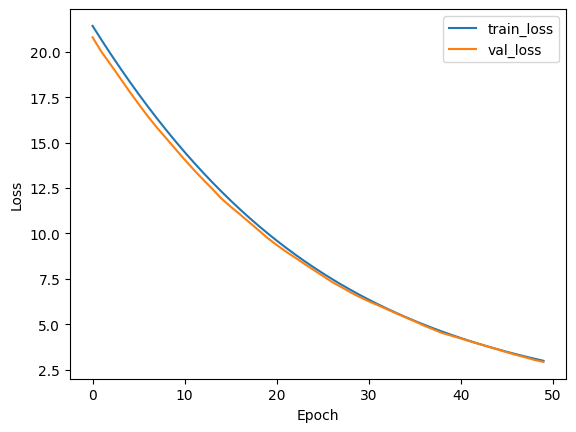

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,510,661 (5.76 MB)

 Trainable params: 1,505,541 (5.74 MB)

 Non-trainable params: 5,120 (20.00 KB)

None


2024/05/30 10:03:40 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 34.2045 - mae: 0.2684 - val_loss: 33.2212 - val_mae: 0.4943
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 33.0615 - mae: 0.2655 - val_loss: 32.1098 - val_mae: 0.4943
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 31.9486 - mae: 0.2629 - val_loss: 31.0280 - val_mae: 0.4943
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 30.8651 - mae: 0.2603 - val_loss: 29.9759 - val_mae: 0.4943
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 29.8115 - mae: 0.2576 - val_loss: 28.9532 - val_mae: 0.4942
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 28.7875 - mae: 0.2553 - val_loss: 27.9595 - val_mae: 0.4938
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 27.7930 - mae: 0.2533 - val_loss: 26.9923 - val_mae: 0.4910
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 26.8270 - mae: 0.2505 - val_loss: 26.0433 - val_mae: 0.4761
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 25.8898 - mae: 0.2485 -

2024/05/30 10:10:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
Error cuadrático medio: 0.01307682041078806
Error absoluto medio: 0.09166847914457321
Coeficiente de determinación: 0.005449175834655762


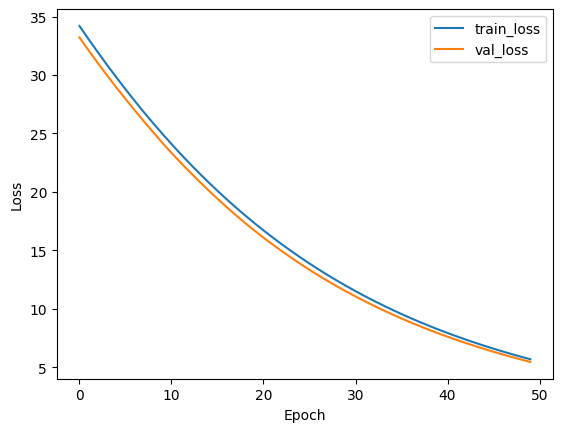

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,844,741 (7.04 MB)

 Trainable params: 1,837,061 (7.01 MB)

 Non-trainable params: 7,680 (30.00 KB)

None


2024/05/30 10:10:52 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 47.0438 - mae: 0.2621 - val_loss: 45.5828 - val_mae: 0.2926
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 45.5545 - mae: 0.2593 - val_loss: 44.1182 - val_mae: 0.2736
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 44.1009 - mae: 0.2571 - val_loss: 42.6996 - val_mae: 0.2758
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 42.6841 - mae: 0.2545 - val_loss: 41.2999 - val_mae: 0.2438
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 41.3035 - mae: 0.2519 - val_loss: 39.9418 - val_mae: 0.2179
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 39.9586 - mae: 0.2496 - val_loss: 38.6190 - val_mae: 0.1916
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 38.6493 - mae: 0.2472 - val_loss: 37.3313 - val_mae: 0.1610
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 37.3752 - mae: 0.2448 - val_loss: 36.0868 - val_mae: 0.1439
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 36.1360

2024/05/30 10:20:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Error cuadrático medio: 0.013054868206381798
Error absoluto medio: 0.09143465757369995
Coeficiente de determinación: 0.007118701934814453


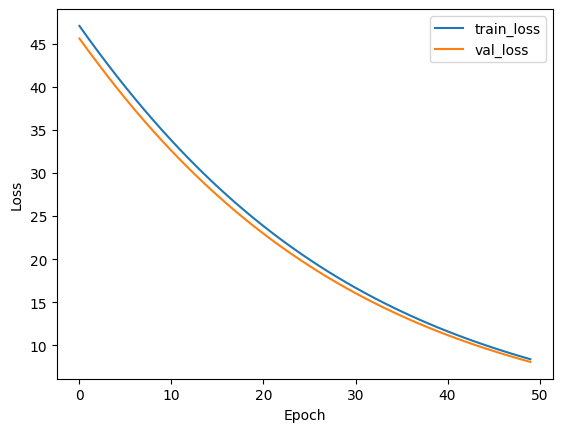

In [12]:
num_hidden_layers_candidates = [5, 10, 15]
for num_hidden_layers in num_hidden_layers_candidates:
    pipeline(num_hidden_layers, 256, 'relu')

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_43 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 961,669 (3.67 MB)

 Trainable params: 959,621 (3.66 MB)

 Non-trainable params: 2,048 (8.00 KB)

None


2024/05/30 10:21:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 18.7558 - mae: 0.2658 - val_loss: 18.2719 - val_mae: 0.4912
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 18.1145 - mae: 0.2637 - val_loss: 17.6494 - val_mae: 0.4912
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 17.4908 - mae: 0.2618 - val_loss: 17.0458 - val_mae: 0.4912
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 16.8864 - mae: 0.2603 - val_loss: 16.4607 - val_mae: 0.4912
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 16.3001 - mae: 0.2585 - val_loss: 15.8940 - val_mae: 0.4912
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 15.7324 - mae: 0.2568 - val_loss: 15.3458 - val_mae: 0.4912
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 15.1828 - mae: 0.2544 - val_loss: 14.8158 - val_mae: 0.4912
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.6520 - mae: 0.2530 - val_loss: 14.2986 - val_mae: 0.4859
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 14.1389 - mae: 0.2512 - v

2024/05/30 10:24:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Error cuadrático medio: 0.06998886168003082
Error absoluto medio: 0.22712674736976624
Coeficiente de determinación: -4.322967052459717


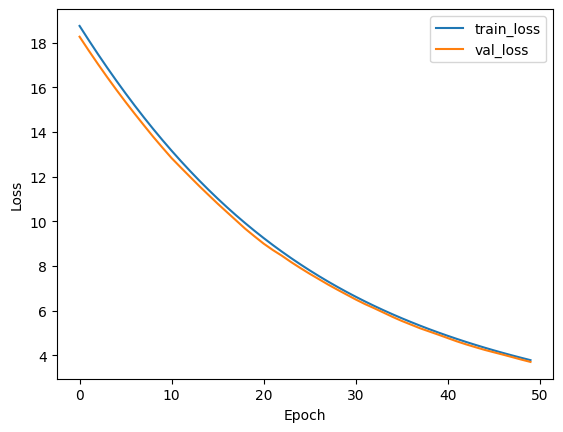

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,377,029 (5.25 MB)

 Trainable params: 1,372,933 (5.24 MB)

 Non-trainable params: 4,096 (16.00 KB)

None


2024/05/30 10:24:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 29.0965 - mae: 0.2749 - val_loss: 28.2504 - val_mae: 0.4997
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 28.0897 - mae: 0.2724 - val_loss: 27.2718 - val_mae: 0.4997
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 27.1092 - mae: 0.2693 - val_loss: 26.3200 - val_mae: 0.4997
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 26.1559 - mae: 0.2669 - val_loss: 25.3951 - val_mae: 0.4990
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 25.2301 - mae: 0.2643 - val_loss: 24.4939 - val_mae: 0.4953
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 24.3311 - mae: 0.2619 - val_loss: 23.6127 - val_mae: 0.4842
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 23.4587 - mae: 0.2597 - val_loss: 22.7377 - val_mae: 0.4351
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 22.6126 - mae: 0.2573 - val_loss: 21.9455 - val_mae: 0.4793
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 21.7928 - mae: 0.2553 - v

2024/05/30 10:30:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Error cuadrático medio: 0.01973026432096958
Error absoluto medio: 0.11379928141832352
Coeficiente de determinación: -0.500575065612793


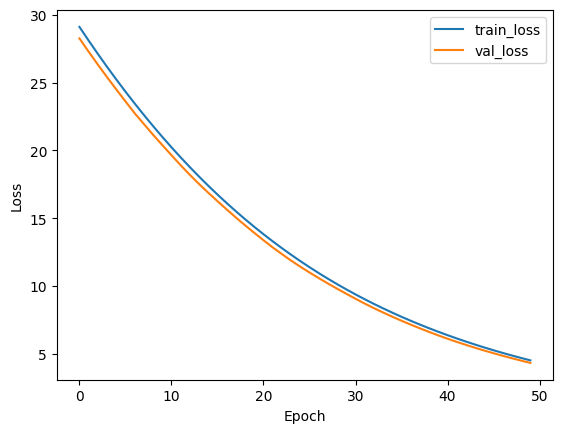

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,895,877 (11.05 MB)

 Trainable params: 2,887,685 (11.02 MB)

 Non-trainable params: 8,192 (32.00 KB)

None


2024/05/30 10:30:32 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - loss: 48.7434 - mae: 0.2751 - val_loss: 46.9363 - val_mae: 0.5067
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 46.7683 - mae: 0.2720 - val_loss: 45.0205 - val_mae: 0.5057
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - loss: 44.8512 - mae: 0.2685 - val_loss: 43.1624 - val_mae: 0.5063
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 42.9910 - mae: 0.2658 - val_loss: 41.3251 - val_mae: 0.4629
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 41.1863 - mae: 0.2624 - val_loss: 39.6037 - val_mae: 0.4959
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 39.4389 - mae: 0.2598 - val_loss: 37.8749 - val_mae: 0.4505
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 37.7471 - mae: 0.2566 - val_loss: 36.1877 - val_mae: 0.3703
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 36.1112 - mae: 0.2537 - val_loss: 34.5928 - val_mae: 0.3290
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - loss: 34.5300

2024/05/30 10:43:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Error cuadrático medio: 0.013035422191023827
Error absoluto medio: 0.0913262665271759
Coeficiente de determinación: 0.00859767198562622


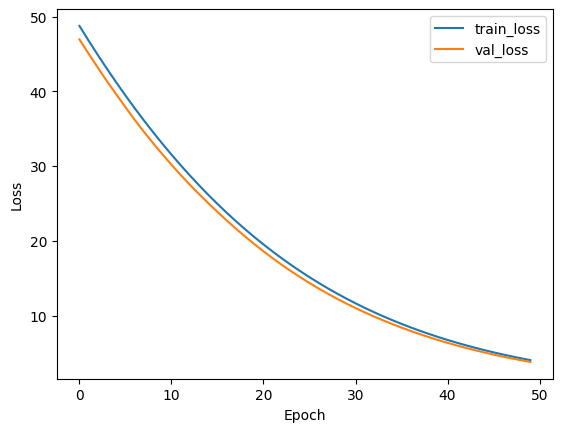

In [13]:
num_hidden_units_candidates = [128, 256, 512]
for num_hidden_units in num_hidden_units_candidates:
    pipeline(8, num_hidden_units, 'relu')

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 857,669 (3.27 MB)

 Trainable params: 856,133 (3.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


2024/05/30 10:43:35 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 15.8982 - mae: 0.2487 - val_loss: 15.5223 - val_mae: 0.4841
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 15.3610 - mae: 0.2465 - val_loss: 15.0136 - val_mae: 0.4953
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.8411 - mae: 0.2452 - val_loss: 14.5107 - val_mae: 0.4947
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.3382 - mae: 0.2441 - val_loss: 14.0222 - val_mae: 0.4915
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.8518 - mae: 0.2424 - val_loss: 13.5456 - val_mae: 0.4831
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.3815 - mae: 0.2403 - val_loss: 13.0949 - val_mae: 0.4852
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.9283 - mae: 0.2391 - val_loss: 12.6226 - val_mae: 0.4236
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.4909 - mae: 0.2375 - val_loss: 12.2170 - val_mae: 0.4567
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.0695 - mae: 0.2360 - v

2024/05/30 10:46:11 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 3s 993us/step
Error cuadrático medio: 0.026331765577197075
Error absoluto medio: 0.12691190838813782
Coeficiente de determinación: -1.0026488304138184


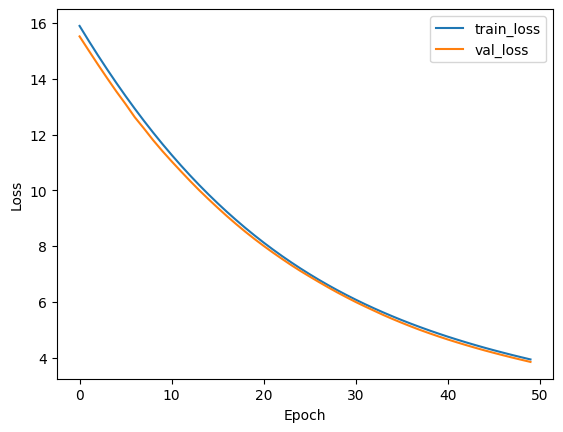

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 857,669 (3.27 MB)

 Trainable params: 856,133 (3.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


2024/05/30 10:46:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 15.9289 - mae: 0.2827 - val_loss: 15.2938 - val_mae: 0.0951
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 15.3863 - mae: 0.2814 - val_loss: 14.7684 - val_mae: 0.0947
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.8602 - mae: 0.2802 - val_loss: 14.2605 - val_mae: 0.0966
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.3510 - mae: 0.2792 - val_loss: 13.7683 - val_mae: 0.0957
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.8584 - mae: 0.2780 - val_loss: 13.2932 - val_mae: 0.0959
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.3826 - mae: 0.2768 - val_loss: 12.8344 - val_mae: 0.0953
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.9229 - mae: 0.2752 - val_loss: 12.3917 - val_mae: 0.0941
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.4802 - mae: 0.2744 - val_loss: 11.9650 - val_mae: 0.0925
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.0531 - mae: 0.2730 - v

2024/05/30 10:48:51 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Error cuadrático medio: 0.013123863376677036
Error absoluto medio: 0.09200238436460495
Coeficiente de determinación: 0.0018712878227233887


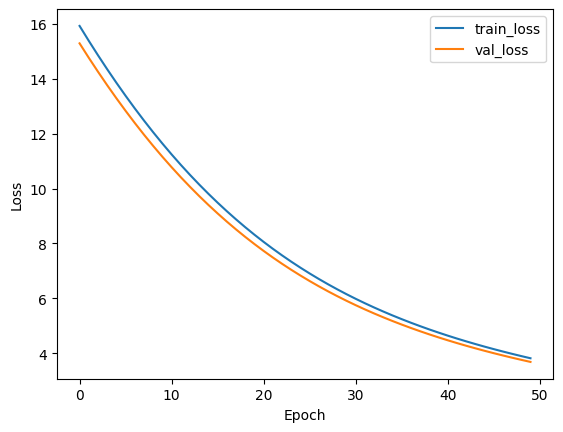

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_101 (Dense)               │ (None, 512)            │       775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 857,669 (3.27 MB)

 Trainable params: 856,133 (3.27 MB)

 Non-trainable params: 1,536 (6.00 KB)

None


2024/05/30 10:48:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 15.9393 - mae: 0.2738 - val_loss: 15.3223 - val_mae: 0.1371
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 15.3964 - mae: 0.2728 - val_loss: 14.7963 - val_mae: 0.1365
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.8698 - mae: 0.2714 - val_loss: 14.2870 - val_mae: 0.1360
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 14.3599 - mae: 0.2700 - val_loss: 13.7945 - val_mae: 0.1354
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.8667 - mae: 0.2686 - val_loss: 13.3188 - val_mae: 0.1349
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 13.3903 - mae: 0.2673 - val_loss: 12.8596 - val_mae: 0.1344
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.9307 - mae: 0.2662 - val_loss: 12.4167 - val_mae: 0.1338
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.4870 - mae: 0.2646 - val_loss: 11.9899 - val_mae: 0.1333
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 12.0598 - mae: 0.2636 - v

2024/05/30 10:51:41 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


2811/2811 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Error cuadrático medio: 0.019266096875071526
Error absoluto medio: 0.11391502618789673
Coeficiente de determinación: -0.4652731418609619


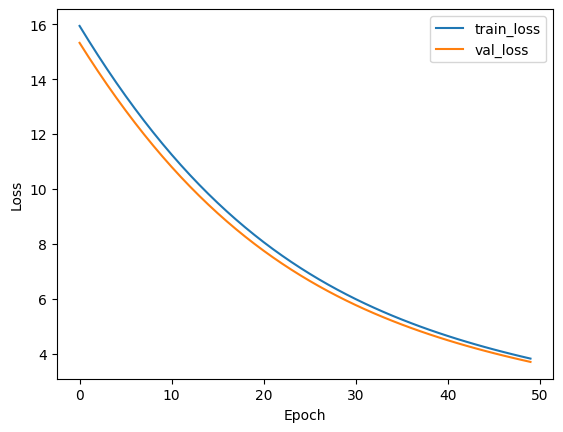

In [14]:
activation_func_candidates = ['relu', 'tanh', 'sigmoid']
for activation_func in activation_func_candidates:
    pipeline(12, 64, activation_func)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 512)            │        35,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 436,229 (1.66 MB)

 Trainable params: 433,669 (1.65 MB)

 Non-trainable params: 2,560 (10.00 KB)

None


2024/05/30 16:53:30 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


Epoch 1/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 14.1388 - mae: 0.2743
Epoch 1: val_loss improved from inf to 11.31334, saving model to model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 14.0681 - mae: 0.2739 - val_loss: 11.3133 - val_mae: 0.0919
Epoch 2/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10.7227 - mae: 0.2523
Epoch 2: val_loss improved from 11.31334 to 8.44878, saving model to model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 10.6654 - mae: 0.2518 - val_loss: 8.4488 - val_mae: 0.0923
Epoch 3/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7.9839 - mae: 0.2229
Epoch 3: val_loss improved from 8.44878 to 6.21338, saving model to model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - loss: 7.9389 - mae: 0.2221 - val_loss: 6.2134 - val_mae: 0.0920
Epoch 4/250
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5.8481 - mae: 0.1773
Epoch 4: val_loss improved from 6.21338 to 4.50996, saving model to model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 5.8136 - mae: 0

2024/05/30 17:37:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Cellar/python@3.11/3.11.9/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."
2024/05/30 17:37:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: The configured tracking uri scheme: 'file' is invalid for use with the proxy mlflow-artifact scheme. The allowed tracking schemes are: {'https', 'http'}


28101/28101 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step
Error cuadrático medio: 0.012126474641263485
Error absoluto medio: 0.08837421238422394
Coeficiente de determinación: 0.086151123046875


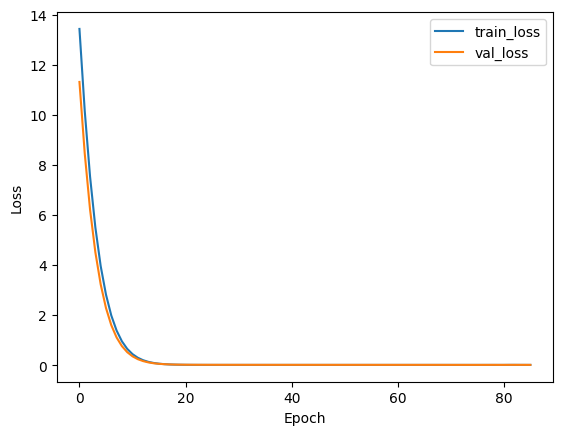

In [12]:
# Final selected Model
pipeline(5, 256, 'relu', epochs=250, save_model=True)